# Tutorial 5 - Implementing Weinhardt et al. (2024)

In this section we are going to set up the RNN as implemented by *Weinhardt et al (2024)* (https://openreview.net/forum?id=x2WDZrpgmB).

This RNN includes RNN-modules for approximating goal-directed behavior (`x_value_reward`) as well non-goal-directed behavior (`x_value_choice`).

Our synthetic participant has the parameters `beta_choice` and `alpha_choice`, which are handling the non-goal-directed behavior in the form of a choice-perseverance bias.

This choice-perseverance bias makes the participant prefer to repeat previously chosen actions by increasing `x_value_choice` if chosen previously and decreasing if not chosen anymore.

For that we are going to follow these steps:

1. add the new memory-state value `x_value_choice` in `init_values`
2. add new RNN-modules to process `x_value_choice` -> `x_value_choice_chosen` and `x_value_choice_chosen`
3. add a sigmoid activation to the new RNN-modules and a scaling factor for the new value to prevent exploding values
4. adapt the forward-method

    4.1 handle the calls of the new RNN-modules

    4.2 add the updated value `x_value_choice` to the logit

5. adjust the SINDy-configuration accordingly

We are going to keep here the participant-embedding even though we are not going to simulate different agents. We just have to make sure to set the participant-IDs in the dataset to `0`.

## 1. Data generation

First of all we have to generate a dataset with multiple participants. Let's start with two different ones.

We are going generate half the dataset with participant #1 and the other half with participant #2.

In [1]:
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

In [2]:
from spice.resources.bandits import BanditsDrift, AgentQ, create_dataset
from spice.resources.rnn_utils import DatasetRNN

# Set up the environment
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

# Set up the agent
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.5,
    alpha_penalty=0.5,
    forget_rate=0.2,
    beta_choice=1.,
    alpha_choice=1.,
)

# Create the dataset
n_trials = 200
n_sessions = 256

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# set participant ids to 0
dataset.xs[..., -1] = 0.
print(f'Number of participants: {len(dataset.xs[..., -1].unique())}')

/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating dataset...


100%|██████████| 256/256 [00:01<00:00, 178.24it/s]

Number of participants: 1


## 2. Using the precoded model

First we setup and train the precoded SPICE model and inspect its behavior, before implementing it ourselves.

In [3]:
from spice.estimator import SpiceEstimator
import spice.precoded as spc

spice_estimator = SpiceEstimator(
    rnn_class=spc.Weinhardt2024RNN,
    spice_config=spc.WEINHARDT_2024_CONFIG,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    convergence_threshold=0,
    n_participants=1,
    scheduler=False,
    spice_optim_threshold=0.05,
    spice_optim_regularization=0.1,
    spice_participant_id=0,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)

Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.

Training the RNN...
Epoch 1/1024 --- L(Train): 0.6925208; Time: 0.22s; Convergence: 6.54e-01
Epoch 2/1024 --- L(Train): 0.6891259; Time: 0.21s; Convergence: 3.29e-01
Epoch 3/1024 --- L(Train): 0.6827177; Time: 0.20s; Convergence: 1.67e-01
Epoch 4/1024 --- L(Train): 0.6517206; Time: 0.21s; Convergence: 9.92e-02
Epoch 5/1024 --- L(Train): 0.5725701; Time: 0.21s; Convergence: 8.92e-02
Epoch 6/1024 --- L(Train): 0.5271963; Time: 0.21s; Convergence: 6.73e-02
Epoch 7/1024 --- L(Train): 0.5136692; Time: 0.21s; Convergence: 4.04e-02
Epoch 8/1024 --- L(Train): 0.5024850; Time: 0.21s; Convergence: 2.58e-02
Epoch 9/1024 --- L(Train): 0.4911116; Time: 0.2

  0%|          | 0/1 [00:00<?, ?it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 2.2823e-02 ... 6.6423e-02 ... 1.4091e-02 ... 4.3556e-02
(x_learning_rate_reward)[k+1] = 0.459 1 + 0.064 c_reward[k]

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.3595e-03 ... 5.0000e-02 ... 2.2741e-02 ... 2.9101e-02
(x_value_reward_not_chosen)[k+1] = 0.125 1 + 0.785 x_value_reward_not_chosen[k]

SINDy model for x_value_choice_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 5.6407e-07 ... 3.0807e-02 ... 2.3836e-02 ... 2.6917e-02
(x_value_choice_chosen)[k+1] = 0.947 1

SINDy model for x_value_choice_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.9699e-05 ... 3.436

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

SPICE training finished.
Training took 219.63 seconds.


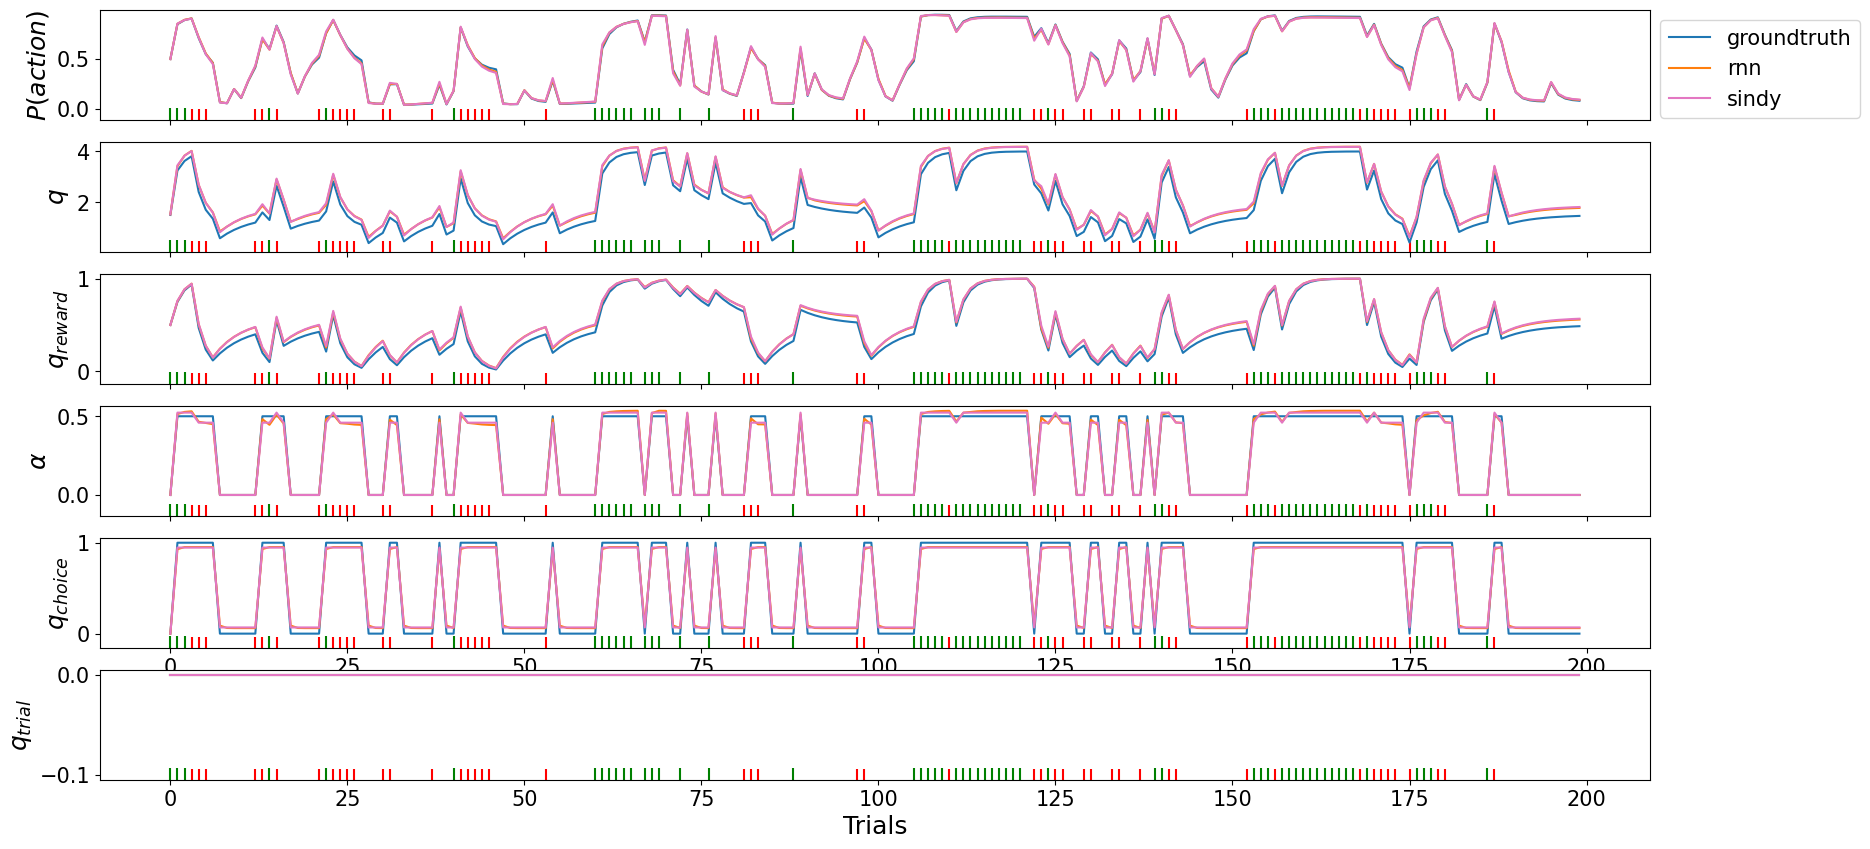

In [4]:
from spice.utils.plotting import plot_session
import matplotlib.pyplot as plt

# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}
fig, axs = plot_session(agents, dataset.xs[0])

## 3. Implementing the RNN from Scratch

Below is the actual implementation of the RNN model by Weinhardt et al. (2024).

In [5]:
from spice.estimator import SpiceConfig
from spice.resources.rnn import BaseRNN

custom_config = SpiceConfig(
    rnn_modules=['x_learning_rate_reward', 'x_value_reward_not_chosen', 'x_value_choice_chosen', 'x_value_choice_not_chosen'],
    control_parameters=['c_action', 'c_reward', 'c_value_reward'],
    # The new module which handles the not-chosen value, does not need any additional inputs except for the value
    library_setup = {
        # 'x_value_reward_chosen': ['c_reward'] -> Remove this one from the library as we are not going to identify the dynamics of a hard-coded equation
        'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
        'x_value_reward_not_chosen': [],
        'x_value_choice_chosen': [],
        'x_value_choice_not_chosen': [],
    },

    # Further, the new module should be applied only to the not-chosen values
    filter_setup = {
        # 'x_value_reward_chosen': ['c_action', 1, True], -> Remove this one as well
        'x_learning_rate_reward': ['c_action', 1, True],
        'x_value_reward_not_chosen': ['c_action', 0, True],
        'x_value_choice_chosen': ['c_action', 1, True],
        'x_value_choice_not_chosen': ['c_action', 0, True],
    }    
)

class CustomRNN(BaseRNN):

    init_values = {
            'x_value_reward': 0.5,
            'x_value_choice': 0.,
            'x_learning_rate_reward': 0.,
        }

    def __init__(
        self,
        n_actions,
        n_participants,
        **kwargs,
    ):
        
        super(CustomRNN, self).__init__(n_actions=n_actions, list_signals=custom_config.spice_feature_list)
        
        # set up the participant-embedding layer
        self.embedding_size = 8
        self.participant_embedding = torch.nn.Sequential(
            torch.nn.Embedding(num_embeddings=n_participants, embedding_dim=self.embedding_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.25),
            )
        
        # scaling factor (inverse noise temperature) for each participant for the values which are handled by an hard-coded equation
        self.betas = torch.nn.ModuleDict()
        self.betas['x_value_reward'] = torch.nn.Sequential(torch.nn.Linear(self.embedding_size, 1), torch.nn.ReLU())
        self.betas['x_value_choice'] = torch.nn.Sequential(torch.nn.Linear(self.embedding_size, 1), torch.nn.ReLU())
        
        # set up the submodules
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2+self.embedding_size, dropout=0.25)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0+self.embedding_size, dropout=0.25)
        self.submodules_rnn['x_value_choice_chosen'] = self.setup_module(input_size=0+self.embedding_size, dropout=0.25)
        self.submodules_rnn['x_value_choice_not_chosen'] = self.setup_module(input_size=0+self.embedding_size, dropout=0.25)
        
        # set up hard-coded equations
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, embedding_variables, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs
        participant_id, _ = embedding_variables
        
        # Here we compute now the participant embeddings for each entry in the batch
        participant_embedding = self.participant_embedding(participant_id[:, 0].int()) # TODO: check if this is correct
        beta_reward = self.betas['x_value_reward'](participant_embedding)
        beta_choice = self.betas['x_value_choice'](participant_embedding)
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
            self.record_signal('x_learning_rate_reward', self.state['x_learning_rate_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            self.record_signal('x_value_choice_chosen', self.state['x_value_choice'])
            self.record_signal('x_value_choice_not_chosen', self.state['x_value_choice'])
            
            # updates for x_value_reward
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            # updates for x_value_choice
            next_value_choice_chosen = self.call_module(
                key_module='x_value_choice_chosen',
                key_state='x_value_choice',
                action=action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
                )
            
            next_value_choice_not_chosen = self.call_module(
                key_module='x_value_choice_not_chosen',
                key_state='x_value_choice',
                action=1-action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
                )
            
            # updating the memory state
            self.state['x_learning_rate_reward'] = learning_rate_reward
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            self.state['x_value_choice'] = next_value_choice_chosen + next_value_choice_not_chosen
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] * beta_reward + self.state['x_value_choice'] * beta_choice
            
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

Library setup is valid. All keys and features appear in the provided list of features.


In [6]:
from spice.estimator import SpiceEstimator

spice_estimator = SpiceEstimator(
    rnn_class=CustomRNN,
    spice_config=custom_config,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    convergence_threshold=0,
    n_participants=1,
    scheduler=False,
    spice_optim_threshold=0.05,
    spice_optim_regularization=0.1,
    spice_participant_id=0,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)


Training the RNN...
Epoch 1/1024 --- L(Train): 0.7356623; Time: 0.22s; Convergence: 6.32e-01
Epoch 2/1024 --- L(Train): 0.6992975; Time: 0.21s; Convergence: 3.34e-01
Epoch 3/1024 --- L(Train): 0.6954205; Time: 0.21s; Convergence: 1.69e-01
Epoch 4/1024 --- L(Train): 0.6936627; Time: 0.20s; Convergence: 8.54e-02
Epoch 5/1024 --- L(Train): 0.6932695; Time: 0.20s; Convergence: 4.29e-02
Epoch 6/1024 --- L(Train): 0.6932061; Time: 0.20s; Convergence: 2.15e-02
Epoch 7/1024 --- L(Train): 0.6932573; Time: 0.21s; Convergence: 1.08e-02
Epoch 8/1024 --- L(Train): 0.6931911; Time: 0.21s; Convergence: 5.42e-03
Epoch 9/1024 --- L(Train): 0.6931372; Time: 0.20s; Convergence: 2.74e-03
Epoch 10/1024 --- L(Train): 0.6931738; Time: 0.20s; Convergence: 1.39e-03
Epoch 11/1024 --- L(Train): 0.6932303; Time: 0.21s; Convergence: 7.21e-04
Epoch 12/1024 --- L(Train): 0.6932041; Time: 0.21s; Convergence: 3.74e-04
Epoch 13/1024 --- L(Train): 0.6931964; Time: 0.20s; Convergence: 1.91e-04
Epoch 14/1024 --- L(Train)

  0%|          | 0/1 [00:00<?, ?it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.1770e-03 ... 5.7114e-02 ... 1.3889e-02 ... 2.8777e-02
(x_learning_rate_reward)[k+1] = 0.498 1

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 2.0066e-04 ... 5.0000e-02 ... 2.2706e-02 ... 2.7907e-02
(x_value_reward_not_chosen)[k+1] = 0.122 1 + 0.787 x_value_reward_not_chosen[k]

SINDy model for x_value_choice_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.5264e-03 ... 5.0000e-02 ... 1.2254e-02 ... 2.0781e-02
(x_value_choice_chosen)[k+1] = 0.455 1

SINDy model for x_value_choice_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.7819e-08 ... 1.3036e-02 ... 1.0600e-03

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

SPICE training finished.
Training took 219.93 seconds.


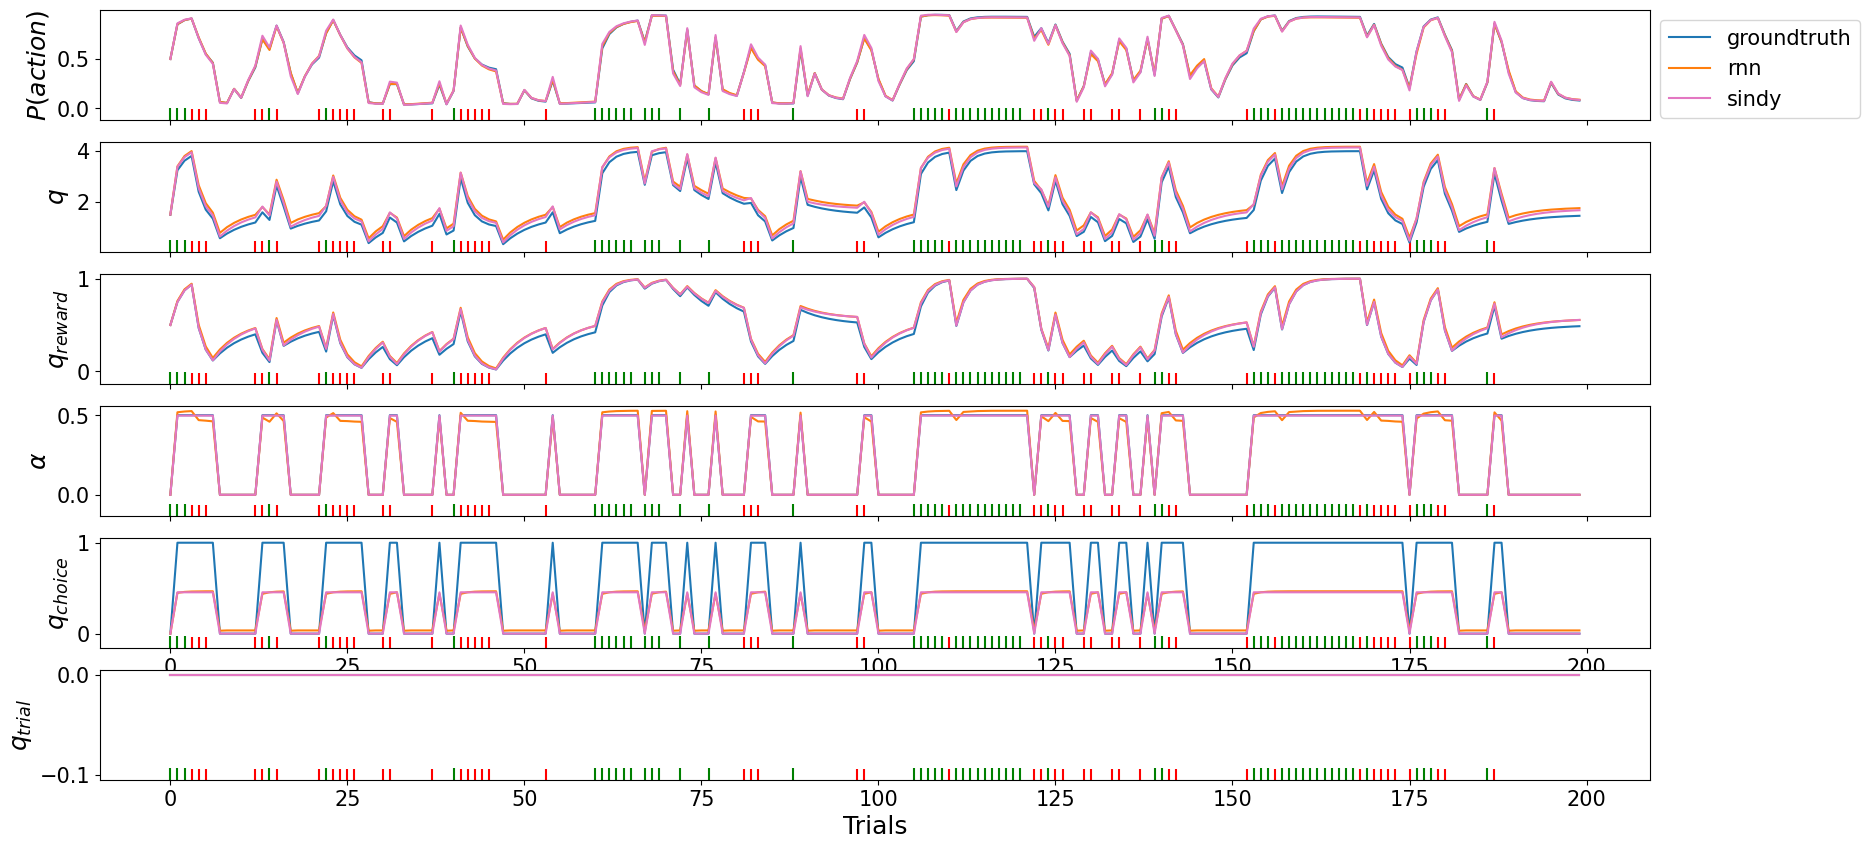

In [7]:
from spice.utils.plotting import plot_session
import matplotlib.pyplot as plt

# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}
fig, axs = plot_session(agents, dataset.xs[0])